
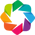

holoviews version 1.9.2


In [1]:
import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
from holoviews.operation.datashader import aggregate, shade, datashade, dynspread
hv.notebook_extension('bokeh','matplotlib')

import numpy as np
import pandas as pd

#import pymc3 as pm

print('holoviews version',hv.__version__)

In [216]:
# def var_with_subscript_string(var,n):
#     return '{0}{1}'.format(var,chr(0x2080 + n))
# var_with_subscript_string("\N{GREEK SMALL LETTER SIGMA}", 3)

import unicodedata as ucd
class DimName(object):
    # https://en.wikipedia.org/wiki/Unicode_subscripts_and_superscripts
    @staticmethod
    def lcg(s, n=None):
        l = ucd.lookup('greek small letter ' + s) 
        if n is None: return l
        else:         return '{0}{1}'.format(l,chr(0x2080 + n))
    @staticmethod
    def ucg(s, n=None):
        l = ucd.lookup('greek capital letter ' + s) 
        if n is None: return l
        else:         return '{0}{1}'.format(l,chr(0x2080 + n))
    @staticmethod
    def subscript(s,n): return '{0}{1}'.format(s,chr(0x2080 + n))
                                                                     
DimName.lcg('alpha'), DimName.lcg('alpha',1),DimName.lcg('sigma'),  DimName.ucg('sigma',0), DimName.subscript('x',2)

('α', 'α₁', 'σ', 'Σ₀', 'x₂')

In [129]:
%%opts ErrorBars [invert_axes=True shared_axes=False show_grid=True  width=600 height=200] (color='slateblue')  {+axiswise}
%%opts Scatter [tools=['hover'] toolbar='above'  shared_axes=False] (color='slateblue' marker='+' size=10 line_width=3)  {+axiswise}

def forest_plot(
    df = pd.DataFrame( 
        {'mean'       : [2.0, 4.0, 6.0,   8.0 ],
         'hpd_2.5'    : [0.0, 2.0, 4.0,   6.0 ],
         'hpd_97.5'   : [3.0, 5.0, 7.0,   9.0 ],
         'sd'         : [0.5, 0.5, 0.5,   0.5 ],}, index=[DimName.lcg('alpha'), DimName.lcg('beta', 0),DimName.lcg('beta', 1),DimName.lcg('sigma')]
)):
    rng = (np.floor(df['hpd_2.5'].min()), np.ceil(df['hpd_97.5'].max()) )

    e_u = df['hpd_97.5']- df['mean']
    e_l = df['mean']   - df['hpd_2.5']

    # Use invisible (i.e., alpha=0) markers to enable hover information
    h = \
        hv.ErrorBars( [i for i in zip(df.index,  df['mean' ], e_l, e_u)],
                    kdims=['parameter'], vdims=['value','e_l','e_u']).opts(style=dict(line_width=1) ) \
      * hv.ErrorBars( zip(df.index,  df['mean' ], df['sd' ] ),
                    kdims=['parameter'], vdims=['value','sd' ]).opts(style=dict(line_width=5, lower_head=None, upper_head=None) ) \
      * hv.Scatter( zip(df.index,  df['mean'   ]) ) \
      * hv.Scatter( zip(df.index,  df['hpd_2.5']) ).opts(style=dict(alpha=0)) \
      * hv.Scatter( zip(df.index,  df['hpd_97.5']) ).opts(style=dict(alpha=0))

    return h.redim.range(y=rng).relabel('95% Credible Intervals')

from io import StringIO
forest_plot() + \
forest_plot(
df = pd.read_csv(StringIO(
''',mean,sd,mc_error,hpd_2.5,hpd_97.5
α,    -14.4, 7.0, 0.2, -29.3, -0.6
β__0,   9.2, 2.5, 0.1,   4.4, 14.0
β__1, -11.5, 3.8, 0.2, -18.4, -4.1
'''),index_col=0)
)

:Layout
   .Overlay.A_95_percent_Credible_Intervals.I  :Overlay
      .ErrorBars.I  :ErrorBars   [parameter]   (value,e_l,e_u)
      .ErrorBars.II :ErrorBars   [parameter]   (value,sd)
      .Scatter.I    :Scatter   [x]   (y)
      .Scatter.II   :Scatter   [x]   (y)
      .Scatter.III  :Scatter   [x]   (y)
   .Overlay.A_95_percent_Credible_Intervals.II :Overlay
      .ErrorBars.I  :ErrorBars   [parameter]   (value,e_l,e_u)
      .ErrorBars.II :ErrorBars   [parameter]   (value,sd)
      .Scatter.I    :Scatter   [x]   (y)
      .Scatter.II   :Scatter   [x]   (y)
      .Scatter.III  :Scatter   [x]   (y)

In [ ]:
pd.read_csv('/tmp/foo.csv').reset_index

In [3]:
%%opts Path Scatter Spread [xticks=4 yticks=4 width=455  show_grid=True]
%%opts Path    (alpha=0.1  color='indianred') Curve (color='black')
%%opts Scatter (alpha=0.03 color='slategray' size=5)
%%opts Spread  (alpha=0.2  color='slategray')


def regression_plot_examples():
    # Least squares problem:  measure y = a + b x + gaussian error; use least squares to estimate a and b; repeat
    N=11; NumExperiments = 1000; a=2.; b=1.; sigma=2.8
    x_vals = np.linspace(-int(N/2),int(N/2),N)
    y_meas = a + b*np.repeat(x_vals.reshape(1,N),NumExperiments,axis=0)  + sigma*np.random.randn( NumExperiments, N )
    # compute the least squares estimates for each experiment
    A              = np.vstack([np.ones(N),x_vals]).T
    ab_estim,_,_,_ = np.linalg.lstsq(A,y_meas.T)
    y_estim        = A.dot(ab_estim).T
    y_estim_ave    = y_estim.mean(axis=0) # averaged y estimates    at each x value
    y_estim_std    = y_estim.std (axis=0) # std of   y estimates    at each x value
    y_meas_ave     = y_meas .mean(axis=0) # averaged y measurements at each x value
    y_meas_std     = y_meas .std (axis=0) # std of   y measurements at each e value

    # Plot the noisy data and the least squares estimates 4 different ways:
    # 1) plot each of the experiments overlaid with the average line and eror bars on the line
    # 2) plot each of the lines estimated by least squares overlaid on each other with ave line and eror bars
    # 3) plot each of the experimantal values overlaid with std of the data and the line estimates
    #    jitter the x locations to get a better view of the number of points involved
    # 4) plot the average estimated line overlaid with estimated line values at each x
    h_data        = hv.Path((x_vals,y_meas.T))
    x_jitter      = np.random.uniform(low=-.05,high=.05,size=(N*NumExperiments))
    h_data_pts    = hv.Scatter( ( np.repeat(x_vals, NumExperiments)+x_jitter, y_meas.T.flatten() ))\
                        (style=dict(color='darkblue', alpha=0.5, size=5))
    h_yestim_line = hv.Path((x_vals,y_estim.T))
    h_yestim_ave  = hv.Curve((x_vals,y_estim_ave))
    h_yestim_std  = hv.ErrorBars((x_vals,y_estim_ave,y_estim_std))
    h_yestim_pts  = hv.Scatter( ( np.repeat(x_vals, NumExperiments), y_estim.T.flatten() ))
    h_spreads_pts = hv.Spread((x_vals, y_estim_ave,y_estim_std))*hv.Spread((x_vals, y_meas_ave, y_meas_std)) *\
                    datashade(h_data_pts)
    #h*h_yestim_ave
    h=\
    (h_data       *h_yestim_std*h_yestim_ave).relabel('Experiments y = %3.2f  + %3.2f x + N(0,%3.2f)'%(a,b,sigma)) +\
    (h_yestim_line*h_yestim_std*h_yestim_ave).relabel('Least Squares Estimate Regression Lines') +\
     (h_yestim_ave*h_spreads_pts            ).relabel('Standard Deviations of Measurements and Estimates') +\
     (h_yestim_ave*h_yestim_pts             ).relabel('Standard Deviations of the Estimated Lines')
    h.cols(2)
    return h

regression_plot_examples().relabel('4 Representations of a Regression')

:Layout
   .Overlay.Experiments_y_equals_2_full_stop_00_plus_1_full_stop_00_x_plus_N_left_parenthesis_0_comma_2_full_stop_80_right_parenthesis :Overlay
      .Path.I      :Path   [x,y]
      .ErrorBars.I :ErrorBars   [x]   (y,yerror)
      .Curve.I     :Curve   [x]   (y)
   .Overlay.Least_Squares_Estimate_Regression_Lines                                                                                    :Overlay
      .Path.I      :Path   [x,y]
      .ErrorBars.I :ErrorBars   [x]   (y,yerror)
      .Curve.I     :Curve   [x]   (y)
   .DynamicMap.Standard_Deviations_of_Measurements_and_Estimates                                                                       :DynamicMap   []
   .Overlay.Standard_Deviations_of_the_Estimated_Lines                                                                                 :Overlay
      .Curve.I   :Curve   [x]   (y)
      .Scatter.I :Scatter   [x]   (y)

In [16]:
%%opts Curve [show_grid=True width=500 height=300] (color='black')
%%opts HLine VLine (color='slategray' alpha=0.3)
%%opts Scatter (size=8 color='coral')

hv.Store.add_style_opts(hv.ErrorBars, ['lower_head', 'upper_head'], 'bokeh')

def measurements_and_regression_line():
    N = 10

    x_vals = np.linspace(-10,10,num=N)
    y_vals = 2. + 1.5*x_vals
    y_meas = y_vals + np.random.normal(scale=10.,size=N)
    
    rng = np.floor(min( y_vals.min(),y_meas.min()) )-1, np.ceil( max(y_vals.max(),y_meas.max()) )+1

    h = \
    hv.Curve((x_vals,y_vals)) *hv.HLine(0)*hv.VLine(0) *\
    hv.ErrorBars( (x_vals,y_vals,np.zeros(N), y_meas-y_vals), vdims=['y','0','e'])\
       .opts(style={'lower_head': None, 'upper_head': None})*\
    hv.Scatter((x_vals,y_meas))
    return h.redim.range(x=(-N-1,N+1), y=(rng))

measurements_and_regression_line().relabel('Measurements and Regression Line')

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .ErrorBars.I :ErrorBars   [x]   (y,0,e)
   .Scatter.I   :Scatter   [x]   (y)

In [5]:
%%opts Curve [show_grid=True width=500 height=300] (color='black')
%%opts HLine VLine (color='slategray' alpha=0.3)
%%opts Scatter (size=8 color='coral')

def estimates_and_line():
    N = 10

    x_vals = np.linspace(-10,10,num=N)
    y_vals = 2. + 1.5*x_vals

    y_meas = np.random.uniform(low=-10., high=15.,size=N)
    e_u    = np.random.uniform(high=12., size=N)
    e_l    = np.random.uniform(high= 8., size=N)

    rng = np.floor((y_vals-e_l).min()) -1, np.ceil((y_vals+e_u).max())+1

    h = \
    hv.Curve((x_vals,y_vals)) *hv.HLine(0)*hv.VLine(0) *\
    hv.ErrorBars( (x_vals,y_meas,e_l, e_u), vdims=['y','e_l','e_u'])*\
    hv.Scatter((x_vals,y_meas))
    return h.redim.range(x=(-N-1,N+1), y=(rng))

estimates_and_line().relabel('Measurements and Line')

:Overlay
   .Curve.I     :Curve   [x]   (y)
   .HLine.I     :HLine   [x,y]
   .VLine.I     :VLine   [x,y]
   .ErrorBars.I :ErrorBars   [x]   (y,e_l,e_u)
   .Scatter.I   :Scatter   [x]   (y)

In [149]:
%%opts Scatter.Individual   [width=600] (color='blue',  size=6)
%%opts Scatter.Hierarchical [width=600] (color='green', size=6)
%%opts Path (color='grey' line_width=1)
%%opts Overlay [legend_position='left']

N=30
indv_a = np.random.uniform(size=N)
indv_b = np.random.uniform(size=N)+1.5
hier_a = indv_a + 0.3*np.random.uniform(size=N)
hier_b = np.random.uniform(size=N)

# list of arrays with x,y rows; e.g., hv.Path( [ np.array([[0,0],[1,1],[2,0.5],[0,0]])])
l_paths=[];np.apply_along_axis(lambda x: l_paths.append(x.reshape((2,2))), 1, np.stack([hier_a,hier_b,indv_a,indv_b],axis=1) )

h=\
hv.Scatter((indv_a,indv_b), 'intercept', 'slope', group='Individual',   label='individual'  )*\
hv.Scatter((hier_a,hier_b), 'intercept', 'slope', group='Hierarchical', label='hierarchical')*\
hv.Path(l_paths, ['intercept', 'slope'], label='shrinkage', group='Shrinkage')

h.relabel('Individual/Hierarchical Shrinkage').redim.range(intercept=(0,1.2),slope=(0.,3))

:Overlay
   .Individual.Individual     :Scatter   [intercept]   (slope)
   .Hierarchical.Hierarchical :Scatter   [intercept]   (slope)
   .Shrinkage.Shrinkage       :Path   [intercept,slope]

In [130]:
%%opts Scatter [width=500 tools=['hover']] (size=5  color=Cycle(['red','green','blue']))
#color=op('species'))
# do categorical axes a little better
#    TODO: get hover to display the category
import seaborn as sns
iris            = sns.load_dataset("iris")
iris['species'] = iris['species'].astype('category')

def strip_plot(df,x,y,jitter=.2):
    ticks = [(i,v) for i,v in enumerate(df[x].cat.categories)]
    return hv.Scatter((np.array([df[x].cat.codes+np.random.uniform(-jitter,jitter,size=df.shape[0]), df[y], df[x].cat.codes.astype(float)]).T), kdims=[x],vdims=[y,'color'])\
             .opts(plot=dict(xticks=ticks, color_index=3))
strip_plot( iris, 'species', 'sepal_length').redim.range(species=(-.5,2.5),sepal_length=(4,8.5))

:Scatter   [species]   (sepal_length,color)

In [3]:
%%opts Scatter [width=500 jitter=.4 tools=['hover']] (size=5 color='color')
# do categorical axes a little better: iris['species'].cat.categories[0]
#    TODO: get hover to display the category
import seaborn as sns
iris            = sns.load_dataset("iris")
iris['species'] = iris['species'].astype('category')

def strip_plot(df,x,y,jitter=.2):
    ticks = [(i,v) for i,v in enumerate(df[x].cat.categories)]
    return hv.Scatter((np.array([df[x].cat.codes, df[y], df[x].cat.codes.astype(float)]).T), kdims=[x],vdims=[y,'color'])\
             .opts(plot=dict(xticks=ticks, color_index=x))
strip_plot( iris, 'species', 'sepal_length').redim.range(species=(-.5,2.5),sepal_length=(4,8.5))

:Scatter   [species]   (sepal_length,color)

In [9]:
%%opts Curve [width=500]
def distribution_example():
    def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
        """Kernel Density Estimation with Scipy"""
        # Note that scipy weights its bandwidth by the covariance of the
        # input data.  To make the results comparable to the other methods,
        # we divide the bandwidth by the sample standard deviation here.

        from scipy.stats import gaussian_kde

        kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
        return kde.evaluate(x_grid)


    N      = 1000
    x      = np.random.normal( size = N )
    x_grid = np.linspace(-4.5, 4.5, 100)
    h = \
    hv.Histogram( np.histogram(x, 20, normed=True) ).opts(style=dict(fill_color='slateblue', alpha=0.4) ) * \
    hv.Curve((x_grid, kde_scipy( x, x_grid ))).opts(style=dict( color='red') )
    return h

distribution_example().relabel( 'KDE of samples drawn from a Normal Distribution')

:Overlay
   .Histogram.I :Histogram   [x]   (Frequency)
   .Curve.I     :Curve   [x]   (y)

In [17]:
%%opts Distribution [width=500]
def gen_distribution_example():
    N      = 1000
    x      = np.random.normal( size = N )
    x_grid = np.linspace(-4.5, 4.5, 100)
    def distribution_example(bw):
        # hv now has hv.Distibution
        h = \
        hv.Histogram( np.histogram(x, 20, normed=True) ).opts(style=dict(fill_color='slateblue', alpha=0.4) ).redim.range(Frequency=(0,.6)) * \
        hv.Distribution(x).opts(style=dict( fill_color='red', fill_alpha=0.1), plot=dict(bandwidth=bw) )
        return h
    return distribution_example

hv.DynamicMap( gen_distribution_example(), kdims='bw' ).redim.values( bw=np.arange(0.01,1, .001))\
  .relabel( 'Samples drawn from a Normal Distribution')

:DynamicMap   [bw]

In [7]:
from bokeh.sampledata.iris import flowers
from holoviews.operation import gridmatrix

def splom_example():
    ds = hv.Dataset(flowers)

    grouped_by_species = ds.groupby('species', container_type=hv.NdOverlay)
    grid               = gridmatrix(grouped_by_species, diagonal_type=hv.Histogram)

    plot_opts = dict() #dict(bgcolor='#fafafa')
    style     = dict(alpha=0.5, size=4)

    return grid({'Scatter': {'plot': plot_opts, 'style': style}})
splom_example()

:GridMatrix   [X,Y]
   :NdOverlay   [species]
      :Histogram   [sepal_width]   (sepal_width_frequency)

In [218]:
%%opts Overlay [width=380 height=200]
%%opts HeatMap [colorbar=True colorbar_position='left'] (cmap='Blues')
%%opts Text (color='lightgreen')

iris = flowers

corr = iris[iris['species'] != 'virginica'].corr().abs()
vals   = np.linspace(1,4,4)
m_corr = corr.as_matrix().copy()
m_corr.T[np.triu_indices(4,1)]=np.NaN

img  = hv.HeatMap((vals,vals,m_corr.T[::-1]), ['species','Species']).opts(plot=dict(xticks=corr.columns))
img*hv.Overlay([hv.Text(i+1,j+1, '%.2f'%m_corr[i,3-j]) for j in range(4) for i in range(4-j)])+\
hv.Div( corr.round(2).to_html())

:Layout
   .Overlay.I :Overlay
      .HeatMap.I :HeatMap   [species,Species]   (z)
      .Text.I    :Text   [x,y]
      .Text.II   :Text   [x,y]
      .Text.III  :Text   [x,y]
      .Text.IV   :Text   [x,y]
      .Text.V    :Text   [x,y]
      .Text.VI   :Text   [x,y]
      .Text.VII  :Text   [x,y]
      .Text.VIII :Text   [x,y]
      .Text.IX   :Text   [x,y]
      .Text.X    :Text   [x,y]
   .Div.I     :Div

In [217]:
%%opts Scatter [width=350 height=350] Ellipse (color='red' line_width=3)
def error_concentration_ellipse_example( A = np.random.multivariate_normal([3,1], cov=[[1,5],[5,15]], size=1000), deviations=4):
    h = hv.Scatter(A)

    ave        = A.mean(axis=0)
    A_centered = (A-ave)
    P          = np.cov(A_centered.T)

    import scipy.linalg as linalg

    U,s,v       = linalg.svd(P)
    orientation = np.arctan2(U[1,0],U[0,0])

    width  = deviations*np.sqrt(s[0])
    height = deviations*np.sqrt(s[1])

    h = h*\
    hv.Ellipse( ave[0], ave[1], (width,height), orientation=orientation)\
        .redim.range(x=(3-6,3+6),y=(1-10,1+10))

    return h.relabel( '%d σ  Error Concentration Ellipse' % deviations)

error_concentration_ellipse_example()

:Overlay
   .Scatter.I :Scatter   [x]   (y)
   .Ellipse.I :Ellipse   [x,y]

## Package as Operations  TODO (INCOMPLETE)

In [ ]:
from holoviews.operation import Operation

class forestplot(Operation):
    """
    boxwhisker plot.
    """
    
    label = param.String(default='ForestPlot', doc="""
        Defines the label of the returned Element.""")
    
    def _process(self, element, key=None):
        # Get first and second Element in overlay
        el = element.get(0)
        
        # Get x-values and y-values of curves
        xvals  = el1.dimension_values(0)
        yvals  = el1.dimension_values(1)
        yvals2 = el2.dimension_values(1)
        
        # Return new Element with subtracted y-values
        # and new label
        return el1.clone((xvals, yvals-yvals2),
                         vdims=[self.p.label])